# Lognormal mocks

Our eventual goal is to compare a direct, harmonic-space analysis of a point set with a more traditional, map-space analysis.  We will do this comparison on mock data. In this notebook, we show how to generate a set of points drawn from a "lognormal catalog" and impose a "survey footprint" covering the quarter of the sky with $|\cos\theta|<1/2$ and $\pi/2 < \phi < 3\pi/2$.

In [1]:
import numpy  as np
import healpy as hp
import sys
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# Get a random number generator.
seed = 0
rng  = np.random.default_rng(seed)

First let's show how the basic algorithm works, then we'll show how to call a class to do this for you.

In [3]:
# Code to generate a lognormal catalog of approximately Npnt
# points, assuming a Gaussian angular power spectrum, clg.
def lognormal_catalog(Npnt,clg,nside=256, seed=None):
    """Returns (theta,phi,wt) for about Npnt points.  This
    should be run with Npnt<<Npix=12*nside^2."""
    np.random.seed(seed)
    gmap = hp.synfast(clg,nside,alm=False,pol=False)
    print("gmap in range ({:e},{:e})".format(np.min(gmap),np.max(gmap)))
    emap = np.exp(gmap)
    emap*= Npnt/np.sum(emap)
    print("emap in range ({:e},{:e})".format(np.min(emap),np.max(emap)))
    ngal = rng.poisson(lam=emap,size=emap.size)
    ipix = np.nonzero(ngal>0)[0]
    thta,phi = hp.pix2ang(nside,ipix,lonlat=False)
    wt   = np.ones_like(thta)
    # Now very slightly perturb the positions away from
    # the pixel centers.
    blur = np.sqrt( hp.pixelfunc.nside2pixarea(nside) )
    thta+= blur*rng.uniform(low=-0.5,high=0.5,size=thta.size)
    phi += blur*rng.uniform(low=-0.5,high=0.5,size=thta.size)
    return( (thta,phi,wt) )

In [4]:
# Generate points -- start with full sky
ell  = np.arange(1000)
ell0 = 10.
clg  = 0.01 * (ell0/(ell+ell0))**2
nside= 2048
# Below we will cut to 1/4 of the sky, so let's
# generate a full-sky map of 4x as many objects
# as we "eventually" want ...
npnt_fullsky    = 4 * 100000
thetas,phis,wts = lognormal_catalog(npnt_fullsky,clg,nside,seed)
# and then cut them to the "observed region"
cost = np.cos(thetas)
ww   = np.nonzero( (np.abs(cost)<0.5)&\
                   (phis>np.pi/2)&(phis<3*np.pi/2) )[0]
thetas,phis,wts = thetas[ww],phis[ww],wts[ww]
#
print("Kept {:d} objects in cut.".format(len(wts)))

gmap in range (-3.978870e+00,3.793611e+00)
emap in range (1.055503e-04,2.506137e-01)
Kept 100713 objects in cut.


We want to make sure that the maximum value of "emap" is smaller than 1.

In [5]:
# If we wanted to put more structure in the mask
# here we could "cut out" various pieces of the
# disk, vetoing both data and random points.

Let's visualize these maps

In [6]:
def make_map(thetas,phis,wts,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = 12*nside**2
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5,weights=wts)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

0.0 180.0 -180.0 180.0


dmap in range [0.000000e+00,4.067848e+05].


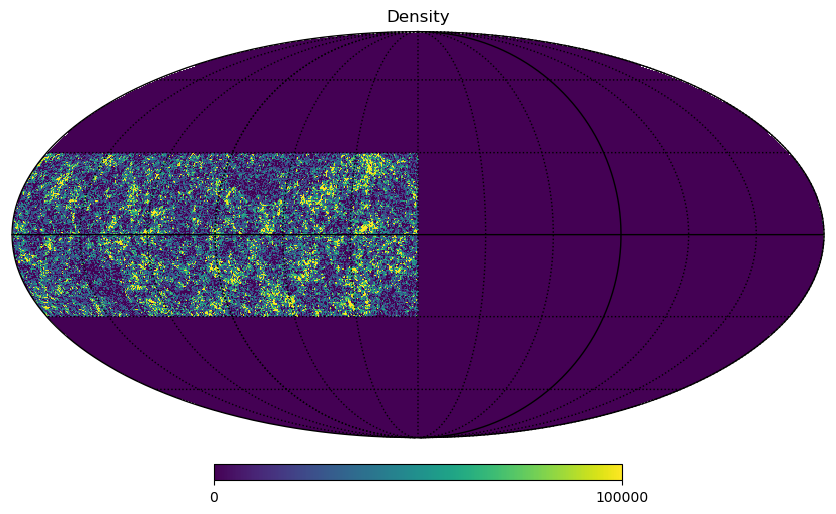

In [7]:
# Show an example at low nside.
nside= 128
dmap = make_map(thetas,phis,wts,nside)
print("dmap in range [{:e},{:e}].".format(np.min(dmap),np.max(dmap)))
#
hp.mollview(dmap,rot=90,max=1e5,title='Density')
hp.graticule()

# Packaging

All of this functionality is packaged in the `LogNormalMocks` class in the `mocks` module.  Here is an example of how to use it.

gmap in range (-3.978870e+00,3.793611e+00)
emap in range (1.055503e-04,2.506137e-01)


0.0 180.0 -180.0 180.0


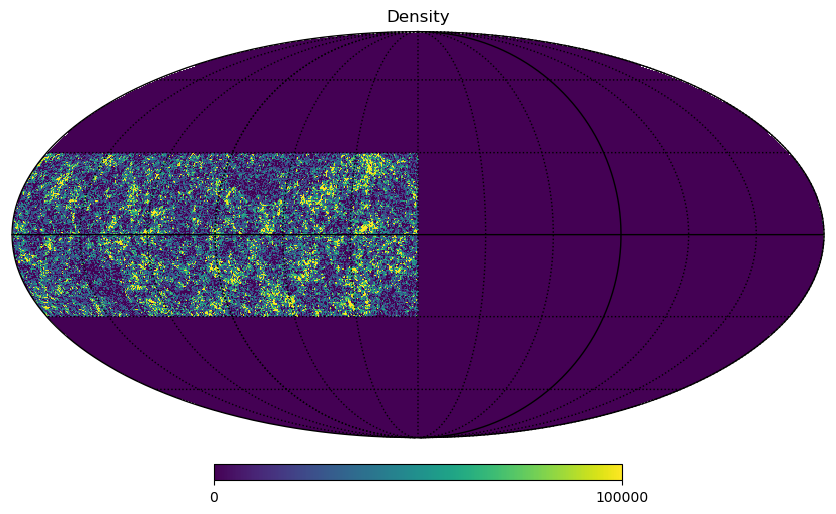

In [8]:
sys.path.append('../sht')
from  mocks import LogNormalMocks
#
# Initialize a helper object from which to draw realizations
# The default power spectrum is the same as used above.
Mocks_obj = LogNormalMocks(npnt_fullsky, nside=2048,
                           theta_range=[np.arccos(0.5), np.arccos(-0.5)],
                           phi_range=[np.pi/2, 3*np.pi/2])
#
# Draw a realization, specifying the random seem if you want
t, p, w = Mocks_obj(seed=0)
dmap_v2 = make_map(t,p,w,nside)
#
hp.mollview(dmap_v2,rot=90,max=1e5,title='Density')
hp.graticule()

This is equivalent to the first approach we presented

In [9]:
np.all(dmap_v2==dmap)

True

But we can easily generate other realizations by playing with the random seed 

gmap in range (-4.084815e+00,3.799855e+00)
emap in range (9.883825e-05,2.625390e-01)


0.0 180.0 -180.0 180.0


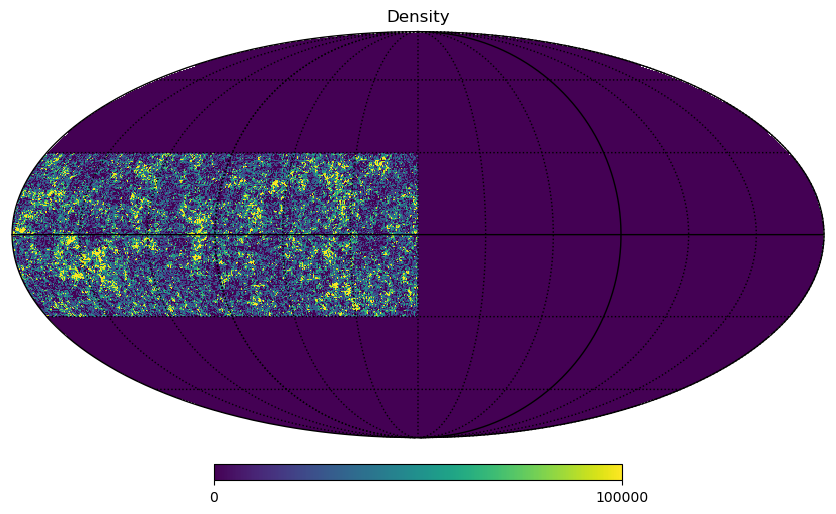

In [10]:
t, p, w = Mocks_obj(seed=4242)
dmap_v2 = make_map(t,p,w,nside)
#
hp.mollview(dmap_v2,rot=90,max=1e5,title='Density')
hp.graticule()

## Expected angular clustering

We can also get the theory $C_\ell$'s underlying the lognormal mocks and compare the measured clustering to this.  The theory is specified by giving the $C_\ell$ of the Gaussian field that is exponentiated, and this defines the spectrum of the lognormal field.

Text(0.5, 1.0, 'Lognormal power spectrum')

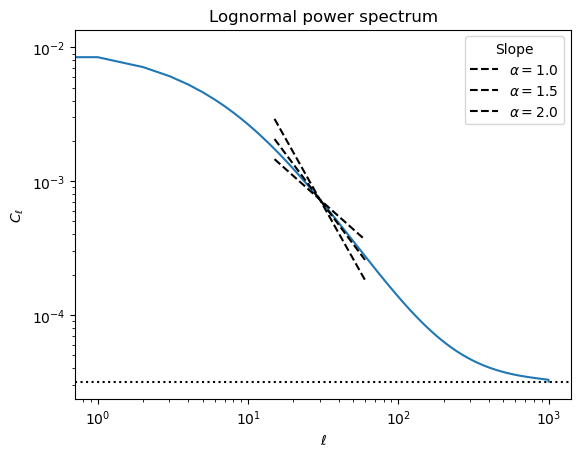

In [11]:
cl_theory = Mocks_obj.get_theory_Cl(lmax_out=1000,gauss_order=3000)
# Plot the theory and shot noise.
plt.loglog(cl_theory)
plt.axhline(4*np.pi/float(Mocks_obj.Npnt),ls=':',color='k')
#
# Plot some power-laws just to guide the eye.
l_pivot = 30
C_pivot = cl_theory[l_pivot]
l_values= np.geomspace(0.5*l_pivot,2.*l_pivot,20)
for slope in [1.0,1.5,2.0]:
    plt.loglog(l_values,C_pivot*(l_pivot/l_values)**slope,\
               ls='--',color='k',\
               label=r'$\alpha='+'{:.1f}$'.format(slope))
#
plt.legend(title='Slope')
plt.ylabel(r'$C_\ell$')
plt.xlabel(r'$\ell$')
plt.title(r'Lognormal power spectrum')

Let's see whether we get this spectrum from many realizations of the mocks.

In [12]:
# Let's compare to measurements on the full-sky
npnt_fullsky,lmax_out = 2e4,500
nbar = npnt_fullsky / (4*np.pi)
#
# Initialize a helper object from which to draw realizations
nside_mockmaking = 2048 # We need Npnt<<Npix=12*nside^2
Mocks_obj = LogNormalMocks(npnt_fullsky,nside=nside_mockmaking)
print('Npnt/Npix = {:e}'.format(npnt_fullsky/(12*nside_mockmaking**2)))
# Get the theory Cls
cl_theory = Mocks_obj.get_theory_Cl(lmax_out=lmax_out,gauss_order=1000)
#
# Draw many realizations and average their measured Cls
nside,Nmc  = 256,50
cl_hat_avg = np.zeros(lmax_out+1)
for i in range(Nmc):
    t, p, w     = Mocks_obj(verbose=False)
    dmap_v2     = make_map(t,p,w,nside) /nbar - 1
    cl_hat_avg += hp.anafast(dmap_v2,lmax=lmax_out)
    if (i+1)%10==0: print("Finished realization {:3d}".format(i+1))
cl_hat_avg /= Nmc

Npnt/Npix = 3.973643e-04
Finished realization  10
Finished realization  20
Finished realization  30
Finished realization  40
Finished realization  50


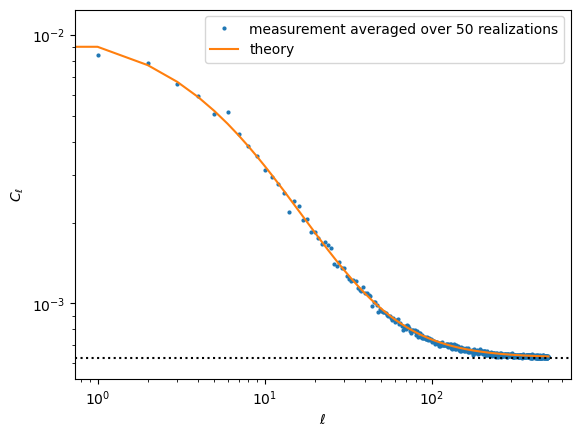

In [13]:
plt.loglog(cl_hat_avg, ls='', marker='o', markersize=2, 
           label='measurement averaged over {:d} realizations'.format(Nmc))
plt.loglog(cl_theory, label='theory')
plt.axhline(4*np.pi/float(Mocks_obj.Npnt),ls=':',color='k')
#
plt.legend()
plt.ylabel(r'$C_\ell$')
plt.xlabel(r'$\ell$')
plt.show()

(-0.5, 0.5)

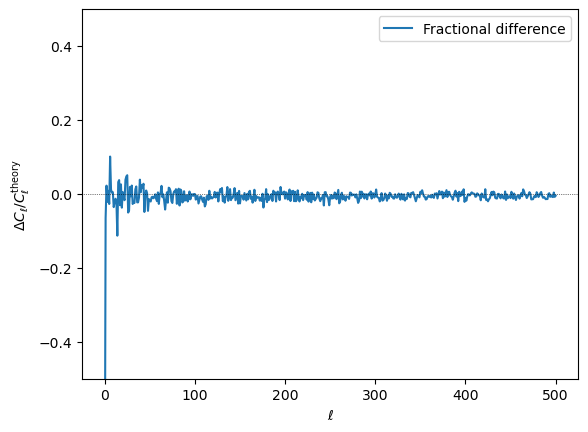

In [14]:
plt.plot((cl_hat_avg-cl_theory)/cl_theory,label='Fractional difference')
plt.axhline(0,ls=':',lw=0.5,color='k')
#
plt.legend()
plt.ylabel(r'$\Delta C_\ell/C_\ell^{\mathrm{theory}}$')
plt.xlabel(r'$\ell$')
plt.ylim([-0.5,0.5])

And actually, it is also possible to provide the $C_{\ell}$'s of the lognormal field when initializing the `LogNormalMocks` object:

In [54]:
# Define some example Cls for the lognormal field
ell  = np.arange(1000)
cl_ln  = 0.01 * (10./(ell+10.))**2

Mocks_obj_v2 = LogNormalMocks(npnt_fullsky, cl_ln=cl_ln)

Everything else is the same.

# The End